# Comparing Elevation Values

Once you have an area of interest with multiple overlapping DEMs and/or laser altimetry measurements, you can quickly compare elevation values. `coincident` supports a main plotting panel for elevation comparisons, as well as dynamic boxplots and histograms for elevation differences over various terrain characteristics and land cover types. See the below functions:
* coincident.plot.compare_dems
* coincident.plot.boxplot_slope
* coincident.plot.boxplot_elevation
* coincident.plot.boxplot_aspect

In [ ]:
import coincident
import geopandas as gpd
from shapely.geometry import box
import rioxarray as rxr
import xarray as xr
import rasterio
import xdem
import numpy as np

%matplotlib inline

Let's go back to our CO site

In [2]:
workunit = "CO_WestCentral_2019"
df_wesm = coincident.search.wesm.read_wesm_csv()
gf_lidar = coincident.search.wesm.load_by_fid(
    df_wesm[df_wesm.workunit == workunit].index
)

gf_lidar

,workunit,workunit_id,project,project_id,start_datetime,end_datetime,ql,spec,p_method,dem_gsd_meters,...,seamless_category,seamless_reason,lpc_link,sourcedem_link,metadata_link,geometry,collection,datetime,dayofyear,duration
0,CO_WestCentral_2019,175984,CO_WestCentral_2019_A19,175987,2019-08-21,2019-09-19,QL 2,USGS Lidar Base Specification 1.3,linear-mode lidar,1.0,...,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,"MULTIPOLYGON (((-106.13571 38.4146, -106.1702 ...",3DEP,2019-09-04 12:00:00,247,29


Now, let's grab the vendor DEM products for two arbitrary tiles of this flight to look at elevation differences between the aerial LIDAR derved DEM, Copernicus GLO-30 DEM, ICESat-2 elevations, and GEDI elevations.

In [3]:
# vendor DEM products
url_tile_1 = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/OPR/Projects/CO_WestCentral_2019_A19/CO_WestCentral_2019/TIFF/USGS_OPR_CO_WestCentral_2019_A19_be_w1032n1780.tif"
url_tile_2 = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/OPR/Projects/CO_WestCentral_2019_A19/CO_WestCentral_2019/TIFF/USGS_OPR_CO_WestCentral_2019_A19_be_w1032n1779.tif"

ds_tile_1 = rxr.open_rasterio(url_tile_1, overview_level=2).to_dataset(name="elevation")
ds_tile_2 = rxr.open_rasterio(url_tile_2, overview_level=2).to_dataset(name="elevation")

ds_lidar = xr.merge([ds_tile_1, ds_tile_2])

In [4]:
# search geodataframe to grab the COP30 DEM
bbox_tile = ds_lidar.rio.bounds()
poly_tile = box(*bbox_tile)
gf_tile = gpd.GeoDataFrame(geometry=[poly_tile], crs=ds_lidar.rio.crs).to_crs(
    "EPSG:4326"
)

In [5]:
# load in COP30 data
gf_cop30 = coincident.search.search(
    dataset="cop30",
    intersects=gf_tile.geometry,
)
ds_cop30 = coincident.io.xarray.to_dataset(
    gf_cop30,
    aoi=gf_tile.geometry,
    mask=True,
).compute()

In [6]:
ds_cop30 = ds_cop30.rename(data="elevation")
ds_cop30 = ds_cop30.rio.reproject(ds_lidar.rio.crs)
ds_cop30_r = ds_cop30.rio.reproject_match(
    ds_lidar, resampling=rasterio.enums.Resampling.bilinear
)

In [7]:
# Get GEDI
gf_gedi = coincident.search.search(
    dataset="gedi",
    intersects=gf_tile,
)
data_gedi = coincident.io.sliderule.subset_gedi02a(
    gf_gedi, gf_tile, include_worldcover=True
)
# Get ICESAT-2
gf_is2 = coincident.search.search(
    dataset="icesat-2",
    intersects=gf_tile,
)
data_is2 = coincident.io.sliderule.subset_atl06(
    gf_is2, gf_tile, include_worldcover=True
)
data_is2_p = data_is2.to_crs(ds_lidar.rio.crs)
data_gedi_p = data_gedi.to_crs(ds_lidar.rio.crs)

### Main Elevation Comparison Panel

'coincident' supports a main `compare_dems` function that allows you to compare multiple DEMs and altimetry points in a single panel. This function dynamically adjusts based on the number of datasets provided.

```{note}
`compare_dems` assumes that all DEMs are in the same coordinate reference system (CRS) and aligned. It also assumes that each DEM has an 'elevation' variable. If hillshade=True, it assumes the first DEM passed has  'hillshade' variable, where the 'hillshade' variable can be calculated with `coincident.plot.create_hillshade` as seen below. A minimum of two DEMs must be provided and a maximum of 5 total datasets (datasets being DEMs and GeoDataFrames of altimetry points) can be provided.
```

In [8]:
# and let's create hillshade variables
ds_lidar["hillshade"] = coincident.plot.hillshade(ds_lidar.elevation)
ds_cop30_r["hillshade"] = coincident.plot.hillshade(ds_cop30_r.elevation)

/home/jehayes/coincident/src/coincident/plot/matplotlib.py:248: RuntimeWarning: invalid value encountered in cast
  return da.dims, data.astype(np.uint8)


/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape geometry at index 0 will not be rasterized.
  warnings.warn(


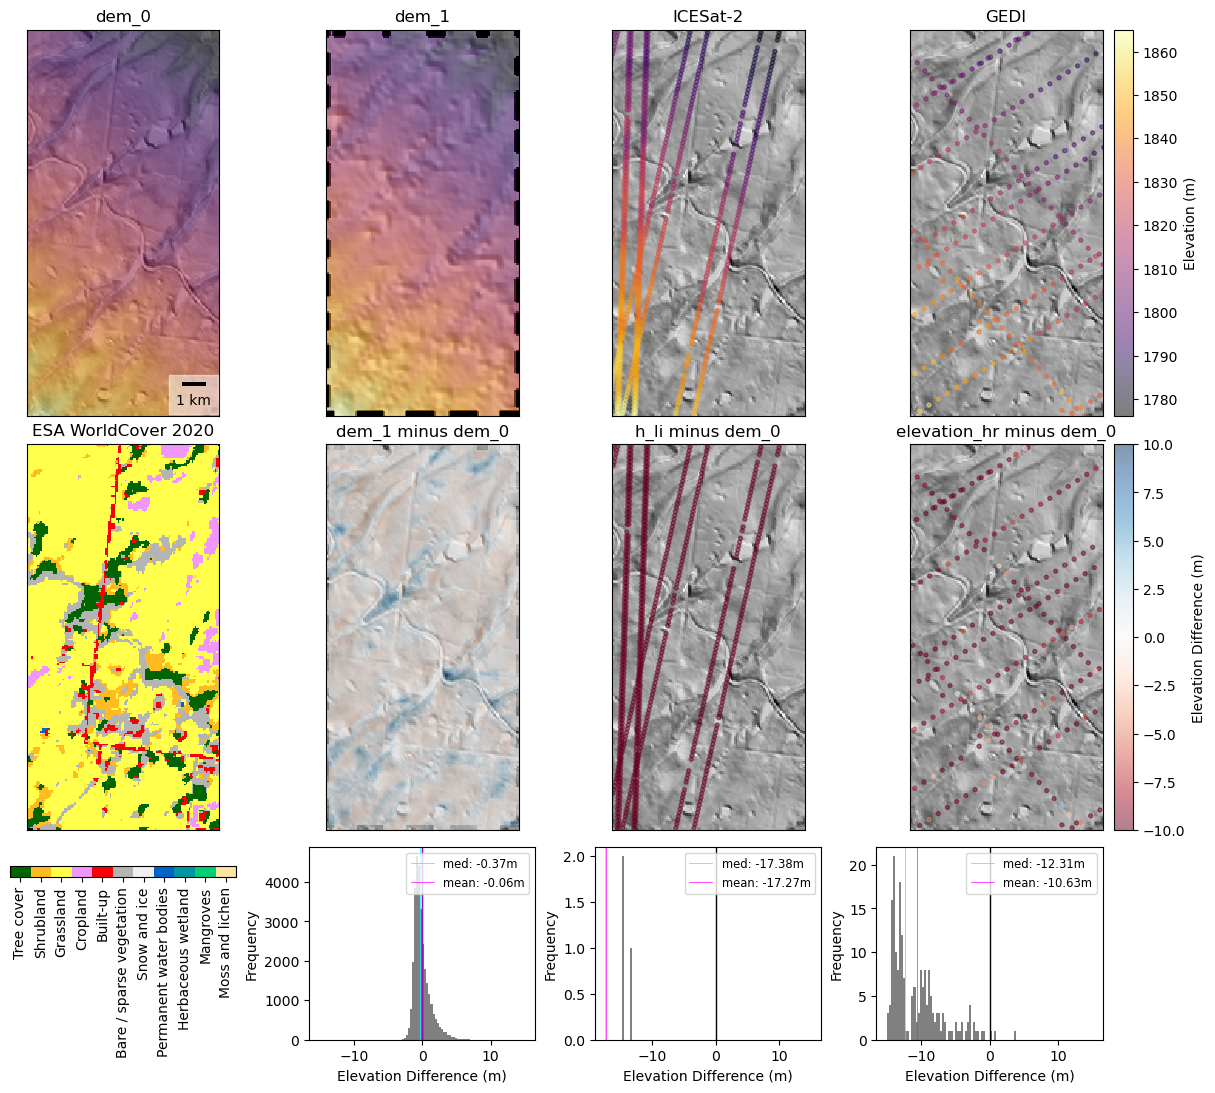

In [9]:
# list of DEMs to compare, where the first DEM in the list is the 'source' DEM
dem_list = [ds_lidar, ds_cop30_r]
# dictionary of GeoDataFrames with altimetry points to compare
# where the key is the name/plot title of the dataset and the value is a tuple of the respective
# GeoDataFrame and the column name of the elevation values of interest
dicts_gds = {"ICESat-2": (data_is2_p, "h_li"), "GEDI": (data_gedi_p, "elevation_hr")}

axd = coincident.plot.compare_dems(
    dem_list,
    dicts_gds,
    diff_clim=(-10, 10),  # difference colormap limits
)

### Dynamic Elevation Difference Boxplots Based on Terrain Variables (slope, elevation, aspect)

`coincident` allows users to dynamically plot elevation differences based on grouped data such as slope values. In these functions (that are wrappers for the generalized coincident.plot.boxplot_terrain_diff function), the user provides a reference DEM and one other DEM or GeoDataFrame with elevation values to compare to. These function assumes that the reference DEM has the respective terrain variable (slope, aspect, etc.) of interest.

```{note}
Boxplots will only be generated with groups of value counts greater than 30. Dynamic ylims will be fit to the IQRs of the boxplots.
```

In [10]:
slope = xdem.terrain.slope(
    ds_lidar.elevation.values, resolution=ds_lidar.rio.resolution()[0]
)
ds_lidar["slope"] = (("y", "x"), np.squeeze(slope))

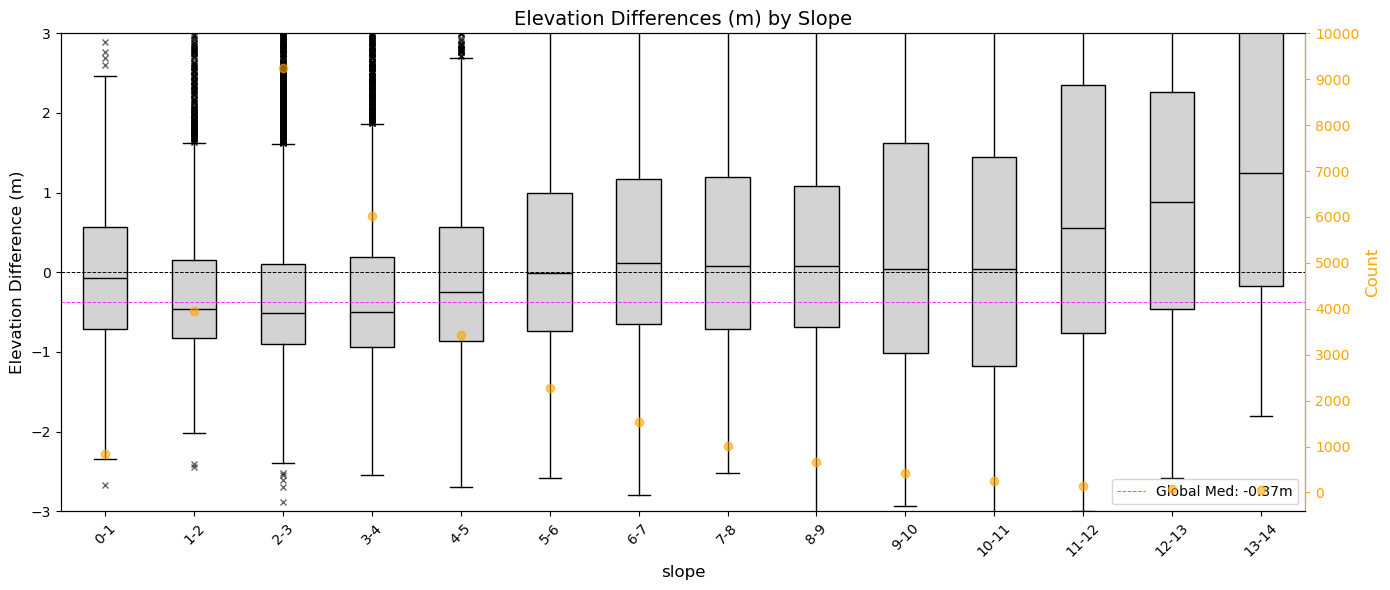

In [11]:
ax_boxplot_dems = coincident.plot.boxplot_slope([ds_lidar, ds_cop30_r])

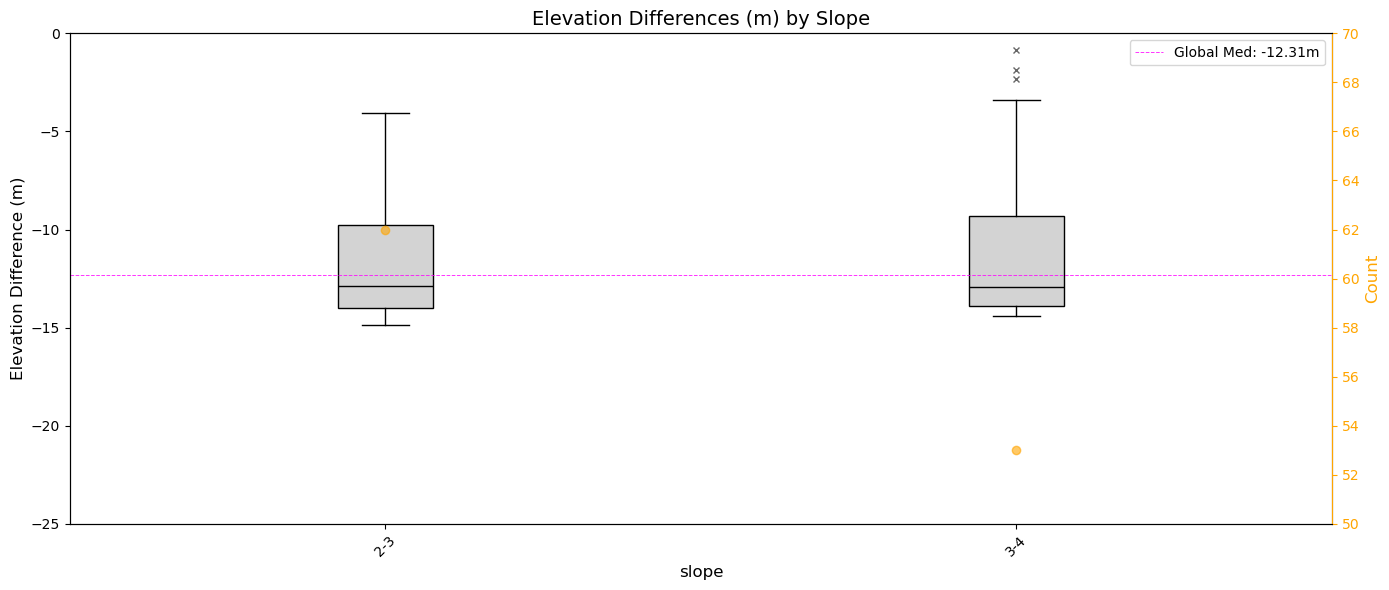

In [12]:
# you can also do the same with a grodataframe point geometry comparison :o
ax_boxplot_gdf = coincident.plot.boxplot_slope(
    [ds_lidar, data_gedi_p],
    elev_col="elevation_hr",
)

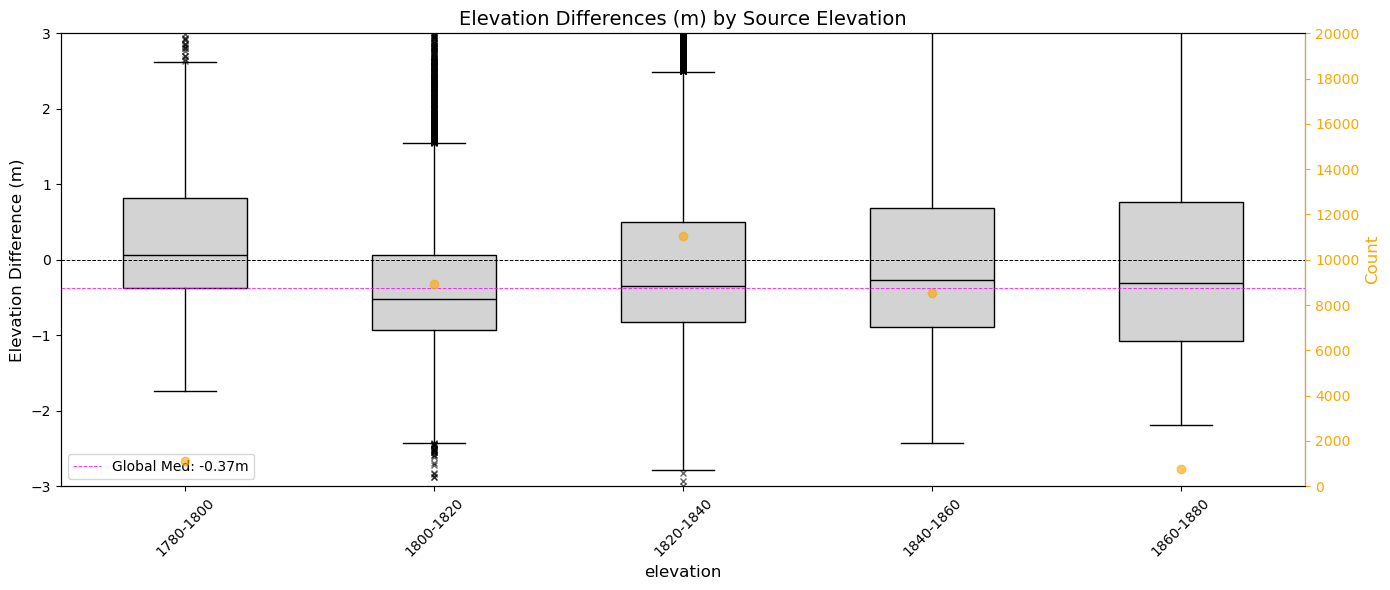

In [13]:
# we also support elevation differences based on elevation bins
# grouped on the reference DEM's elevation values
ax_elev = coincident.plot.boxplot_elevation(
    [ds_lidar, ds_cop30_r], elevation_bins=np.arange(1700, 2000, 20)
)

In [14]:
# lastly for the boxplots, let's look at aspect
aspect = xdem.terrain.aspect(ds_lidar.elevation.values)
ds_lidar["aspect"] = (("y", "x"), np.squeeze(aspect))

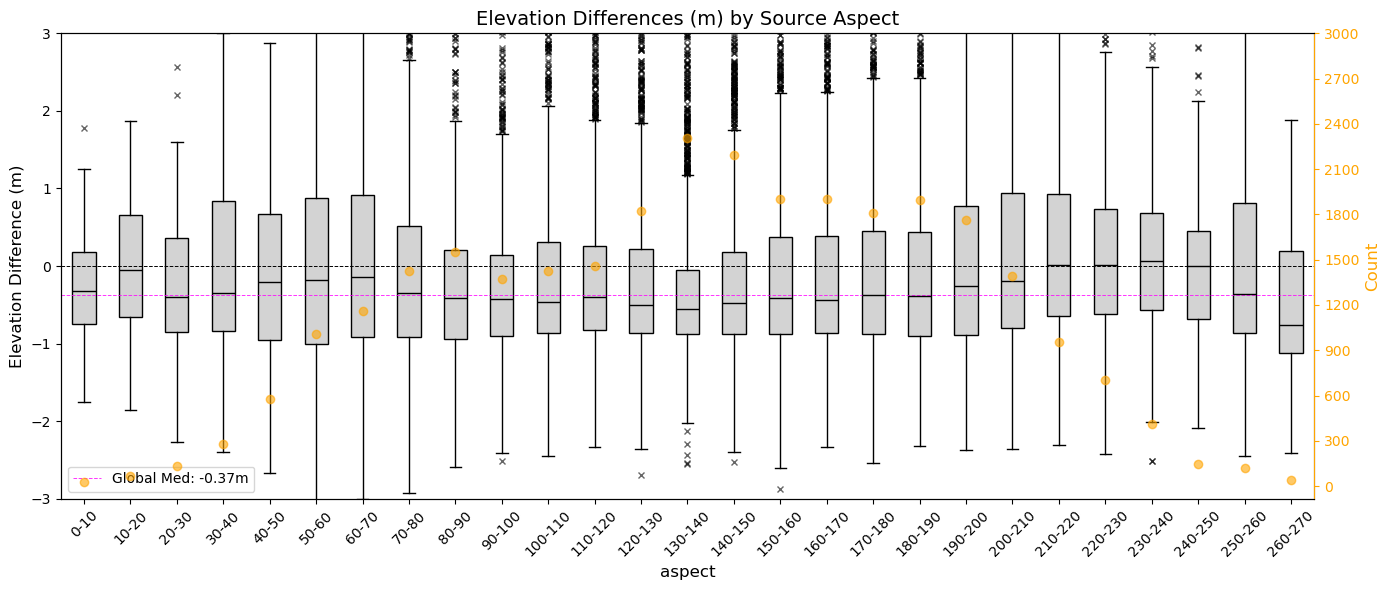

In [15]:
ax_aspect = coincident.plot.boxplot_aspect([ds_lidar, ds_cop30_r])

### Histograms of Elevation Differences over Land Cover

Plot elevation differences between DEMs or point data, grouped by ESA World Cover 2020 land cover class

```{note}
Histograms will only be generated with groups of value counts greater than a user-defined threshold (default is 30).
```

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape geometry at index 0 will not be rasterized.
  warnings.warn(


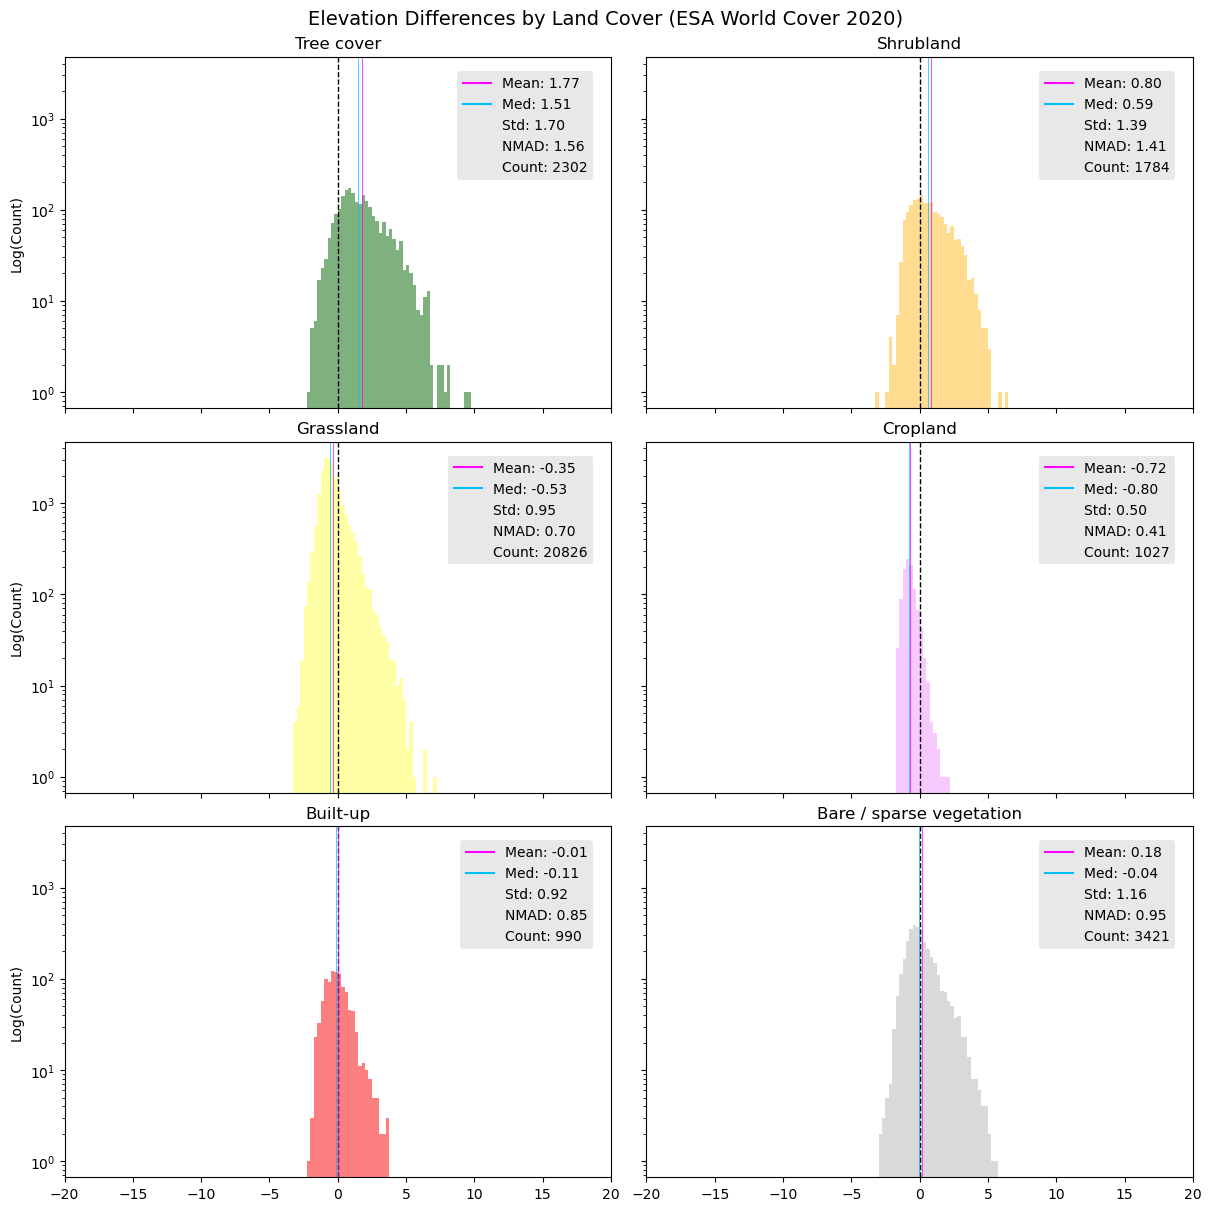

In [16]:
ax_lulc_cop30 = coincident.plot.hist_esa([ds_lidar, ds_cop30_r])

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape geometry at index 0 will not be rasterized.
  warnings.warn(


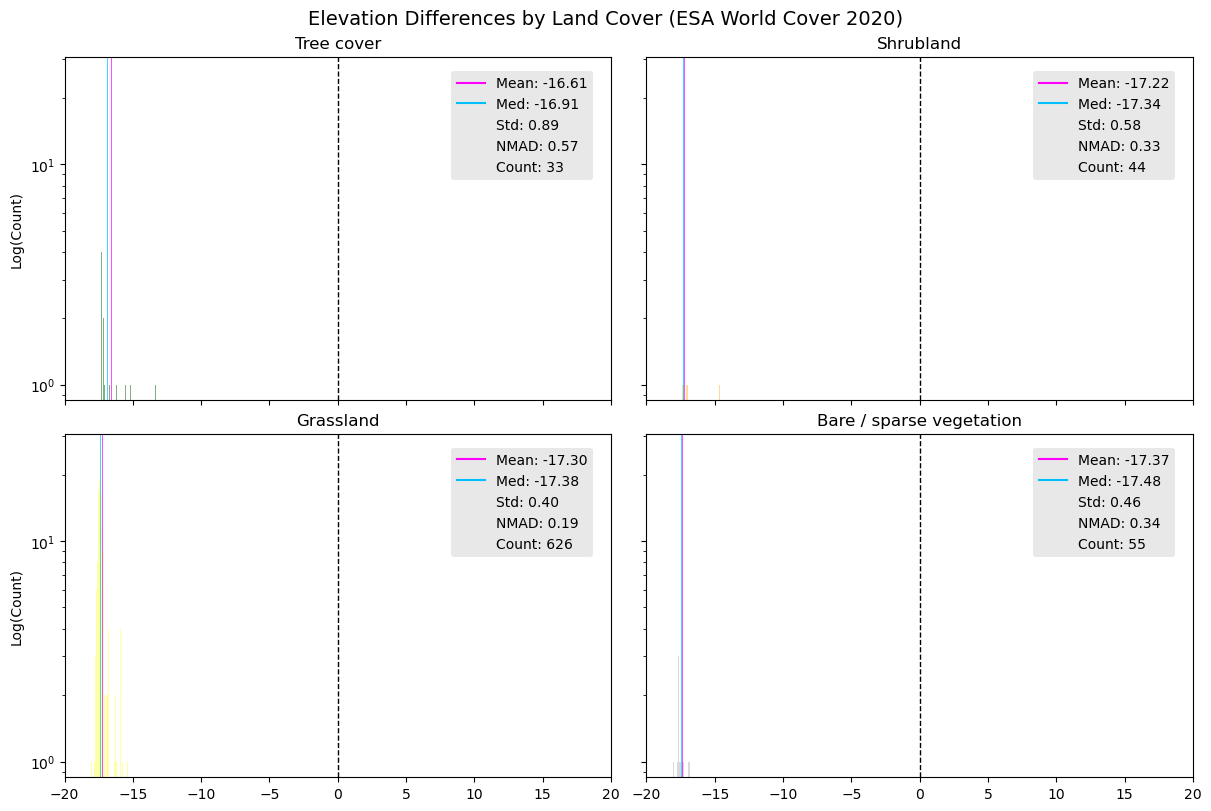

In [17]:
ax_lulc_is2 = coincident.plot.hist_esa([ds_lidar, data_is2_p], elev_col="h_li")